# Сравнение реализаций Pipeline Parallelism

В главе «Обучение больших языковых моделей» мы разобрали несколько подходов, которые можно применить для параллелизации процессов обучения и инференса моделей. Среди них были Data Parallelism, Pipeline Parallelism, Tensor Parallelism и Sequence Parallelism. В этом ноутбуке мы на практике познакомимся с Pipeline Parallelism для инференса и сравним два разных варианта реализации этой техники.

Эксперимент проводился на машине с двумя T4 GPU, поэтому для простоты в коде руками указаны номера используемых устройств. Код нетрудно обобщить на системы с большим числом GPU аналогичным образом. 

Код запускался в окружении с Python 3.10.12 и PyTorch 2.0.0.

## Pipeline Parallelism

Идея этого подхода проста: разобъем слои модели на несколько блоков, которые разнесем по разным устройствам. Таким образом мы сможем запускать модели большего размера за счет использования видеопамяти сразу нескольких устройств.

Рассмотрим **наивный** вариант реализации этой техники, описанный в `pipeline_parallelism_scripts.py`:

```python
def naive_process(dataloader: DataLoader, model_blocks: List[Tuple[nn.Module, str]]) -> Tuple[torch.Tensor, float]:
    processed_data = []
    
    start = time.perf_counter()
    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0]
            for model_block, device in model_blocks:
                batch = model_block(batch.to(device))
            processed_data.append(batch.cpu())
    stop = time.perf_counter()
    
    processing_time = stop - start
    return torch.concatenate(processed_data, dim=0), processing_time
```

Здесь функция обработки данных принимает `model_blocks`. Это список пар `(блок, устройство)`, который описывает разбиение модели. Для упрощения считается, что модель — это композиция последовательных применений блоков из `model_blocks` к данным. В более общем случае `model_blocks` был бы не списком, а ориентированным графом без циклов.

Заметим интересную особенность такой реализации: в каждый момент времени работает не более одного устройства. Сейчас пока получается, что в нашей технике *параллелизации* абсолютно все выполняется *последовательно*, а GPU большую часть времени простаивают. Это будет негативно сказываться на пропускной способности системы.

Чтобы решить возникшую проблему, запустим инференс каждого блока в отдельном процессе, а данные между блоками будем передавать с помощью очередей. Так работает **параллельный** вариант реализации, описанный в `pipeline_parallelism_scripts.py`:

```python
def model_block_worker(model_block: nn.Module, device: str, input_queue: JoinableQueue, output_queue: JoinableQueue):
    while True:
        batch = input_queue.get()
        if batch is None:
            output_queue.put(None)
            break
        with torch.no_grad():
            processed_batch = model_block(batch.to(device))
        output_queue.put(processed_batch)
        del batch
        input_queue.task_done()
    output_queue.join()

def parallel_process(dataloader: DataLoader, model_blocks: List[nn.Module]) -> Tuple[torch.Tensor, float]:
    processed_data = []
    queues = [JoinableQueue() for _ in range(len(model_blocks) + 1)]
    workers = [
        Process(
            target=model_block_worker,
            args=(model_block, device, queues[i], queues[i + 1]),
            daemon=True,
        )
        for i, (model_block, device) in enumerate(model_blocks)
    ]
    
    for worker in workers:
        worker.start()
    
    start = time.perf_counter()
    for batch in dataloader:
        queues[0].put(batch[0])
    queues[0].put(None)
    
    while True:
        processed_batch = queues[-1].get()
        if processed_batch is None:
            queues[-1].task_done()
            break
        processed_data.append(processed_batch.cpu())
        del processed_batch
        queues[-1].task_done()
    stop = time.perf_counter()
    
    for worker in workers:
        worker.terminate()
    
    processing_time = stop - start
    return torch.concatenate(processed_data, dim=0), processing_time
```

Тонкости работы с CUDA тензорами в контексте многопроцессной обработки можно посмотреть в документации PyTorch: [Sharing CUDA tensors](https://pytorch.org/docs/stable/multiprocessing.html#sharing-cuda-tensors).

Технические детали:
* Чтобы consumer мог сигнализировать producer, что он закончил работать с данными, вместо `event.wait()`/`event.set()` из [документации](https://pytorch.org/docs/stable/multiprocessing.html#sharing-cuda-tensors) используются `JoinableQueue`.
* В качестве сигнала конца обработки данных передается `None`.

Функции выше помимо данных возвращают еще и время обработки.

## Сравнение наивной и параллельной реализации

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from pipeline_parallelism_scripts import naive_process, parallel_process

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Callable, Iterable

import torch.multiprocessing as mp
mp.set_start_method('spawn')

В качестве подопытной сети будем использовать **DummyNet**. Эта модель не выполняет никакой осмысленной работы, но ее все еще можно использовать для иллюстрации процесса параллелизации инференса. Так что притворимся, что она занимается чем-то важным, и параллелизуем ее инференс.

In [2]:
class DummyNet(nn.Module):
    def __init__(self):
        super(DummyNet, self).__init__()
        self.block1 = nn.Sequential(
            nn.Linear(2, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2),
            nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.Linear(2, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2),
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        return x

Для реализации Pipeline Parallelism модель необходимо разбить на блоки. С **DummyNet** это делается совсем просто. В общем случае на практике придется вручную подбирать такое разбиение, при котором время инференса всех блоков будет примерно одинаковым. Это необходимо, так как пропускная способность параллельного пайплайна всегда равна пропускной способности его самого медленного блока.

In [3]:
model = DummyNet()
model_blocks = [
    (model.block1, 'cuda:0'),
    (model.block2, 'cuda:1'),
]
for model_block, device in model_blocks:
    model_block.to(device)

Следующая функция будет собирать статистику о времени обработки разных по объему наборов данных.

In [4]:
def get_timings_for_processing_method(
    processing_method: Callable, n_batches_grid: Iterable[int], model_blocks: List[Tuple[nn.Module, str]], 
    batch_size: int = 512, n_repeats: int = 3,
) -> List[List[float]]:
    timing_results = []

    for n_batches in n_batches_grid:
        dataset = TensorDataset(torch.randn(n_batches * batch_size, 2))
        dataloader = DataLoader(dataset, batch_size, num_workers=4)

        processing_times = []
        for _ in range(n_repeats):
            _, processing_time = processing_method(dataloader, model_blocks)
            processing_times.append(processing_time)
        timing_results.append(processing_times)
    
    return timing_results

Соберем статистику о времени обработки данных.

In [5]:
n_batches_grid = range(128, 2048 + 1, 128)
naive_processing_timing_results = get_timings_for_processing_method(naive_process, n_batches_grid, model_blocks)
parallel_processing_timing_results = get_timings_for_processing_method(parallel_process, n_batches_grid, model_blocks)

Как видим по графику, время обработки линейно зависит от количества обрабатываемых данных. Причем у параллельной реализации больше константа, что обусловлено необходимостью инициализации процессов и очередей, и меньше коэффициент за счет большей нагрузки на GPU.

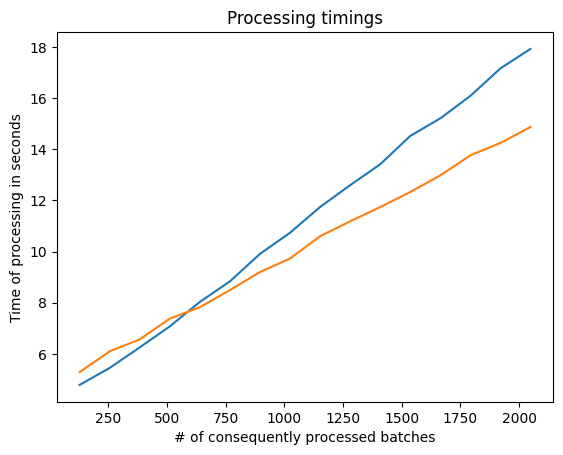

In [6]:
ax = plt.axes()
ax.plot(list(n_batches_grid), np.mean(naive_processing_timing_results, axis=1))
ax.plot(list(n_batches_grid), np.mean(parallel_processing_timing_results, axis=1))
ax.grid(False)
ax.set_title('Processing timings')
ax.set_xlabel('# of consequently processed batches')
ax.set_ylabel('Time of processing in seconds')
plt.show()